In [ ]:
import time
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import  TensorDataset, DataLoader

import os
import copy
import math

from scipy.special import softmax
import scipy.stats as ss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,recall_score,precision_score,precision_recall_curve,f1_score,auc
from prettytable import PrettyTable

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

#torch.cuda.set_device(1)
#os.environ['CUDA_VISIBLE_DEVICES']='1'

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf2 = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0.0001, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >self.patience:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

###**MOMA network for # of module**

In [ ]:
# Number of Module = 32

class mtlAttention(nn.Module):
    def __init__(self, In_Nodes1,In_Nodes2, Modules):
        super(mtlAttention, self).__init__()
        self.Modules = Modules
        self.sigmoid = nn.Sigmoid()

        self.task1_FC1_x = nn.Linear(In_Nodes1, Modules,bias=False)
        self.task1_FC1_y = nn.Linear(In_Nodes1, Modules,bias=False)

        self.task2_FC1_x = nn.Linear(In_Nodes2, Modules,bias=False)
        self.task2_FC1_y = nn.Linear(In_Nodes2, Modules,bias=False)
            
        self.softmax  = nn.Softmax(dim=-1)
        
        self.task1_FC2 =nn.Sequential(nn.Linear(Modules*2, 32),nn.ReLU())
        self.task2_FC2 = nn.Sequential(nn.Linear(Modules*2, 32),nn.ReLU())

        self.task1_FC3 =nn.Sequential(nn.Linear(32, 16),nn.ReLU())
        self.task2_FC3 = nn.Sequential(nn.Linear(32, 16),nn.ReLU())
        
        self.task1_FC4 = nn.Sequential(nn.Linear(16, 1), nn.Sigmoid())
        self.task2_FC4 = nn.Sequential(nn.Linear(16, 1), nn.Sigmoid())

    def forward_one(self,xg,xm):
        xg_x = self.task1_FC1_x(xg)
        xm_x = self.task2_FC1_x(xm)
        xg_y = self.task1_FC1_y(xg)         
        xm_y =self.task2_FC1_y(xm)

        xg = torch.cat([xg_x.reshape(-1,1,self.Modules),xg_y.reshape(-1,1,self.Modules)], dim=1)
        xm = torch.cat([xm_x.reshape(-1,1,self.Modules),xm_y.reshape(-1,1,self.Modules)], dim=1)
        
        norm  = torch.norm(xg, dim=1, keepdim=True)
        xg = xg.div(norm)
        
        norm  = torch.norm(xm, dim=1, keepdim=True)
        xm = xm.div(norm)
        
        energy =  torch.bmm(xg.reshape(-1,2,self.Modules).permute(0,2,1) ,xm.reshape(-1,2,self.Modules))
        attention1 = self.softmax(energy.permute(0,2,1)).permute(0,2,1) 
        attention2 = self.softmax(energy).permute(0,2,1)
        
        xg_value = torch.bmm(xg,attention1) 
        xm_value = torch.bmm(xm,attention2)

        xg = xg_value.view(-1,self.Modules*2)
        xm =xm_value.view(-1,self.Modules*2)
        
        xg = self.task1_FC2(xg)
        xm = self.task2_FC2(xm) 
        xg = self.task1_FC3(xg)
        xm = self.task2_FC3(xm)
        xg = self.task1_FC4(xg)
        xm = self.task2_FC4(xm)
        
        return xg,xm

###**Dataset load**

In [ ]:
# Connect to google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load flux data 
file1 = pd.read_csv('/content/drive/MyDrive/Data/fluxes.csv', encoding='utf-8')

# Load gene expression data 
file2 = pd.read_csv('/content/drive/MyDrive/Data/gene_expression_data.csv', encoding='utf-8')

# Load survival data
file3 = pd.read_csv('/content/drive/MyDrive/Data/survival_data.csv', encoding='utf-8')

# Load flux (metabolic) data as the X variable
X_flux = file1

# Load gene expression data as the X variable
X_gex = file2

# Load survival data as the Y variable
Y = file3

In [ ]:
#Rename unamed (1st) column
X_gex = X_gex.rename(columns={X_gex.columns[0]: 'Risk_factor'})

# Tranpose patient ID  to rows in order to align gene data with fluxes data
X_gex = X_gex.set_index('Risk_factor').T.rename_axis('PatientID').rename_axis(None, axis=1).reset_index()

# Remove 'PatientID' column
X_gex = X_gex.drop(['PatientID'], axis=1)

In [ ]:
# Get instance of MinMaxScaler
ss = MinMaxScaler()

# Normalise gene expression data
X_gex = pd.DataFrame(ss.fit_transform(X_gex), columns=X_gex.columns)

# Normalise fluxes data
X_flux = pd.DataFrame(ss.fit_transform(X_flux), columns=X_flux.columns)

[Text(0.5, 0, 'Event Observed'), Text(0, 0.5, 'No of Records')]

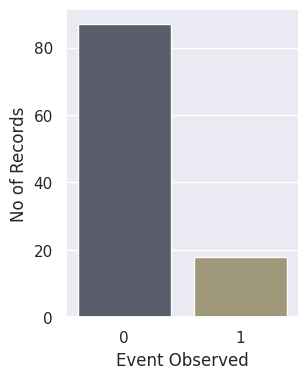

In [ ]:
#Check for imbalanced dataset in target variable

xx = Y['Event'].value_counts().reset_index()
plt.figure(figsize=(3,4))
ax = sns.barplot(x='index', y='Event', data=xx, palette='cividis')
ax.set(xlabel='Event Observed', ylabel='No of Records')

In [ ]:
#Prepare target variable
Y = Y['Event'].to_numpy()

In [ ]:
# Use SMOTE to generate rows for the minority class
smote = SMOTE()

X_gene_data, Y_balanced = smote.fit_resample(X_gex, Y)

X_metabolic_data,_ = smote.fit_resample(X_flux, Y)

In [ ]:
# Check shape of variables
print(X_gene_data.shape)
print(X_metabolic_data.shape)
print(Y_balanced.shape)

(174, 17814)
(174, 3788)
(174,)


In [ ]:
# Set variables for training
xg_data = X_gene_data.values
xm_data = X_metabolic_data.values
label = Y_balanced.astype('float32')


###**Training**

In [ ]:
start = time.time()
j=0
for train_index, test_index in skf.split(xg_data,label):
    Xg_train, Xg_test = xg_data[train_index,:], xg_data[test_index,:]
    Xm_train, Xm_test = xm_data[train_index,:], xm_data[test_index,:]
    yg_train, yg_test = label[train_index], label[test_index]
    j=j+1
    if j==1: ### CV1 test
        break

earlyStoppingPatience = 100
learningRate = 0.0001
weightDecay = 0.01
num_epochs = 500000

y_train = yg_train.flatten().astype(int)
y_test = yg_test.flatten().astype(int)

Xg = torch.tensor(Xg_train, dtype=torch.float32)#.cuda()
Xm = torch.tensor(Xm_train, dtype=torch.float32)#.cuda()

Xg_test = torch.tensor(Xg_test, dtype=torch.float32)#.cuda()
Xm_test = torch.tensor(Xm_test, dtype=torch.float32)#.cuda()

y = torch.tensor(y_train, dtype=torch.float32)#.cuda()

ds = TensorDataset(Xg, Xm,y)
loader  = DataLoader(ds, batch_size=y_train.shape[0],shuffle=True)

#Xg_test = torch.tensor(Xg_test, dtype=torch.float32)#.cuda()
#Xm_test = torch.tensor(Xm_test, dtype=torch.float32)#.cuda()
Xg_test = Xg_test.clone().detach()
Xm_test = Xm_test.clone().detach()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
In_Nodes1 = Xg_train.shape[1] 
In_Nodes2 = Xm_train.shape[1]

# mtlAttention(In_Nodes1,In_Nodes2, # of module)
net = mtlAttention(In_Nodes1,In_Nodes2,32)
net = net.to(device)
early_stopping = EarlyStopping(patience=earlyStoppingPatience, verbose=False)
optimizer = optim.Adam(net.parameters(), lr=learningRate, weight_decay=weightDecay)
loss_fn = nn.BCELoss()

for epoch in (range(num_epochs)):
    running_loss1 = 0.0
    running_loss2 = 0.0
    for i, data in enumerate(loader, 0):
        xg,xm, y = data
        output1,output2 = net.forward_one(xg,xm)
        output1  = output1.squeeze()
        output2  = output2.squeeze()
        net.train()
        optimizer.zero_grad()
        loss = loss_fn(output1, y) + loss_fn(output2, y) 
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss1 += loss_fn(output1,y.view(-1)).item()
        running_loss2 += loss_fn(output2,y.view(-1)).item()


    early_stopping(running_loss1+running_loss2, net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("--------------------------------------------------------------------------------------------------")
        break

    if (epoch+1) % 100 == 0 or epoch == 0:
        if (epoch+1) % 100 == 0 or epoch == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}, BCE_task1; {:.4f}, BCE_task2; {:.4f}'.format(epoch+1,num_epochs, running_loss1+running_loss2,running_loss1,running_loss2))

### Test
            
test1,test2 = net.forward_one(Xg_test.clone().detach(),Xm_test.clone().detach())
test1 = test1.cpu().detach().numpy()
test2 = test2.cpu().detach().numpy()


print ("ACC_task1 %.3f, ACC_task2 %.3f" %(accuracy_score(list(y_test),np.where(test1 > 0.5, 1, 0) ),accuracy_score(list(y_test),np.where(test2 > 0.5, 1, 0))))
print ("F1_task1 %.3f, F1_task2 %.3f" %(f1_score(list(y_test),np.where(test1 > 0.5, 1, 0)),f1_score(list(y_test),np.where(test2 > 0.5, 1, 0))))
print ("AUC_task1 %.3f, AUC_task2 %.3f" %(roc_auc_score(y_test.reshape(-1),test1),roc_auc_score(y_test.reshape(-1),test2)))
print("time :", time.time() - start)

Epoch [1/500000], Loss: 1.3933, BCE_task1; 0.6979, BCE_task2; 0.6954
Epoch [100/500000], Loss: 1.0451, BCE_task1; 0.5336, BCE_task2; 0.5115
Epoch [200/500000], Loss: 0.7280, BCE_task1; 0.3872, BCE_task2; 0.3408
Epoch [300/500000], Loss: 0.4694, BCE_task1; 0.2590, BCE_task2; 0.2105
Epoch [400/500000], Loss: 0.3027, BCE_task1; 0.1723, BCE_task2; 0.1304
Epoch [500/500000], Loss: 0.1811, BCE_task1; 0.1038, BCE_task2; 0.0772
Epoch [600/500000], Loss: 0.1357, BCE_task1; 0.0798, BCE_task2; 0.0559
Epoch [700/500000], Loss: 0.0899, BCE_task1; 0.0516, BCE_task2; 0.0383
Epoch [800/500000], Loss: 0.1794, BCE_task1; 0.1051, BCE_task2; 0.0744
Early stopping
--------------------------------------------------------------------------------------------------
ACC_task1 0.971, ACC_task2 0.971
F1_task1 0.971, F1_task2 0.971
AUC_task1 1.000, AUC_task2 1.000
time : 55.92024493217468


In [ ]:

#Get model parameters

# Instantiate model
model = mtlAttention(In_Nodes1,In_Nodes2,32)

# Load the saved checkpoint into model object
model.load_state_dict(torch.load('checkpoint.pt'))

#Get Model Summary 
def count_parameters(model):
    table = PrettyTable(['Modules', 'Parameters'])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f'Total Trainable Params: {total_params}')
    return total_params

count_parameters(model)


+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| task1_FC1_x.weight |   570048   |
| task1_FC1_y.weight |   570048   |
| task2_FC1_x.weight |   121216   |
| task2_FC1_y.weight |   121216   |
| task1_FC2.0.weight |    2048    |
|  task1_FC2.0.bias  |     32     |
| task2_FC2.0.weight |    2048    |
|  task2_FC2.0.bias  |     32     |
| task1_FC3.0.weight |    512     |
|  task1_FC3.0.bias  |     16     |
| task2_FC3.0.weight |    512     |
|  task2_FC3.0.bias  |     16     |
| task1_FC4.0.weight |     16     |
|  task1_FC4.0.bias  |     1      |
| task2_FC4.0.weight |     16     |
|  task2_FC4.0.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 1387778


1387778

###**Calculate similarity score**

In [ ]:
dim = 32
y_all = np.concatenate((y_train,y_test+2))
Xg_all = np.concatenate((Xg_train,Xg_test.cpu().detach().numpy()))
Xm_all = np.concatenate((Xm_train,Xm_test.cpu().detach().numpy()))
att_all = pd.DataFrame()
sum_all = pd.DataFrame(np.zeros((dim*dim, 1)))

for i in range(y_all.shape[0]):
    xg_x = net.task1_FC1_x(torch.tensor(Xg_all[i].reshape(1,-1)).float())#.cuda())
    xg_y = net.task1_FC1_y(torch.tensor(Xg_all[i].reshape(1,-1)).float())#.cuda())
    xm_x = net.task2_FC1_x(torch.tensor(Xm_all[i].reshape(1,-1)).float())#.cuda())
    xm_y = net.task2_FC1_y(torch.tensor(Xm_all[i].reshape(1,-1)).float())#.cuda())
    xg = torch.cat([xg_x.reshape(-1,1,dim),xg_y.reshape(-1,1,dim)], dim=1)
    xm = torch.cat([xm_x.reshape(-1,1,dim),xm_y.reshape(-1,1,dim)], dim=1)

    norm  = torch.norm(xg, dim=1, keepdim=True)
    xg = xg.div(norm)
    norm2  = torch.norm(xm, dim=1, keepdim=True)
    xm = xm.div(norm2)

    energy =  torch.bmm(xg.reshape(-1,2,dim).permute(0,2,1) ,xm.reshape(-1,2,dim)) 
    att = energy.cpu().detach().numpy().reshape(dim,dim)

    ind = np.empty([dim,dim]).astype(str)
    for a in range(dim):
        for b in range(dim):
            st = 'GE module %s, MB module %s' %(a,b)
            ind[a,b] = st
    atte2 = pd.DataFrame(att.reshape(-1,1),index=ind.reshape(-1,1))
    att_all = pd.concat([att_all,atte2],axis=1)
    if y_all[i]==1:
      sum_all = sum_all.values.reshape(dim,dim)
      atte2 = atte2.values.reshape(dim, dim)
      sum_all = pd.DataFrame(np.add(sum_all, atte2))
    #if y_all[i]==1:
        #sum_all = sum_all.add(atte2, fill_value=0)
sum_all = sum_all[dim*dim:]


###**Visualization of Similarity Score**

/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


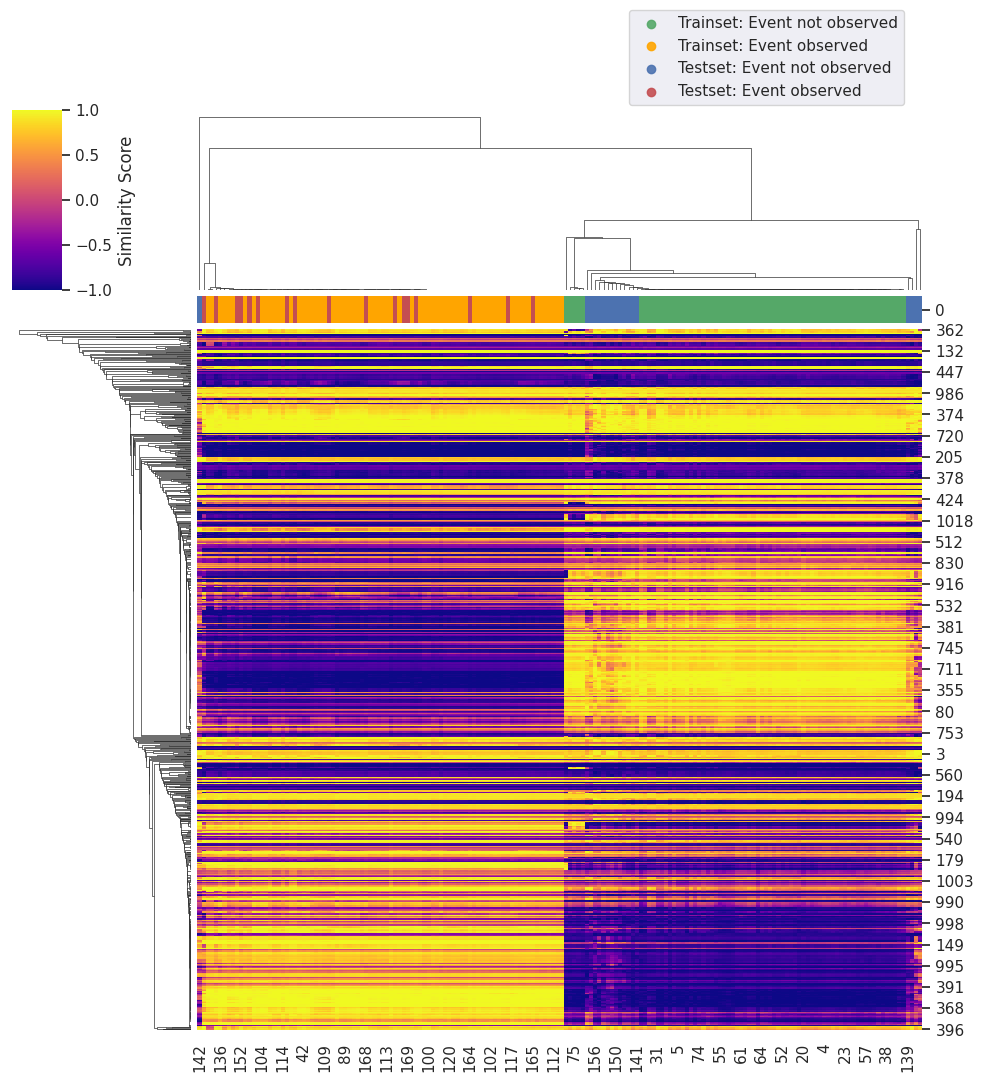

In [ ]:
my_palette =  dict(zip(np.unique(y_all), "rbg"))
my_palette[0]  = 'g'
my_palette[1]  = 'orange'
my_palette[2]  = 'b'
my_palette[3]  = 'r'
row_colors = pd.DataFrame(y_all)[0].map(my_palette)

cluster = sns.clustermap(pd.DataFrame(att_all.values), metric="correlation", method="single", cmap="plasma", col_colors=row_colors,
                         row_cluster=True,dendrogram_ratio=0.2,figsize=(10, 10), cbar_kws={'label': 'Similarity Score'})

# Add legend
legend_labels = ['Trainset: Event not observed', 'Trainset: Event observed', 'Testset: Event not observed', 'Testset: Event observed']
handles = []
labels = []
for label in np.unique(y_all):
    handles.append(plt.scatter([], [], c=my_palette[label], label=legend_labels[label], alpha=0.9))
    labels.append(legend_labels[label])
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(18, 1.6))

plt.show()